# 1. (20 points) 
## 1 Robot1 and Robot2
Robot1 & Robot2 The robot problem is from artificial robot domain in which
robots are described by 6 different attributes. The learning task is a binary clas-
sification task. Perform modelling on both the datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.datatools import train_test_split
from utils.legacy_metrics import precision, recall, f1_score, accuracy

## Helper Functions

### Function to get distance measures

In [2]:
from math import sqrt
def euclidean_dist(point1, point2, dims=None):
    """Returns the euclidean distance between to points, assumes both the points have equal no. of dimensions."""
    no_of_dimensions = dims if dims is not None else len(point1)
    distance = 0

    for i in range(no_of_dimensions):
        distance += (point2[i] - point1[i]) ** 2
    # TODO: take sqrt
    return distance

In [3]:
euclidean_dist([0,0,0],[0,0,0])

0

In [4]:
def get_k_nearest_neighbours(training_df, test_point, k):
    """Returns k nearest neighbours of test_point, among training_points"""
    dimensions = len(test_point) - 1  # -1 to not consider class label when calculating distance
    dists = np.apply_along_axis(euclidean_dist, 1, training_df, test_point, dimensions)
    distances = np.column_stack((dists, training_df))

    distances = distances[distances[:, 0].argsort()]
    k_neighbours = distances[:k, 1:]
    return k_neighbours


def get_k_nearest_neighbours_v2(training_df, test_point, k):
    """Returns k nearest neighbours of test_point, among training_points"""
    training_points = training_df.values
    distances = []
    
    dimensions = len(test_point) - 1  # -1 to not consider class label when calculating distance
    for point in training_points: 
        distance = euclidean_dist(point, test_point, dimensions) 
        distances.append((distance, point)) # append as tuple: (distance, point) 
    
    distances.sort(key=lambda x: x[0]) # sort the points by euclidean_distance
    
    neighbours = []
    for i in range(k):
        neighbours.append(distances[i][1])
    
    return np.array(neighbours)


def best_class(neighbours):
    """Returns most prominent class label among the neighbours"""
    class_labels = neighbours[:,-1]
    unique_labels, counts = np.unique(class_labels, return_counts=True)
    index = counts.argmax()
    return unique_labels[index]

In [5]:
def classify_example(example, training_df, k):
    neighbours = get_k_nearest_neighbours_v2(training_df, example.values, k=k)
    return best_class(neighbours)

In [6]:
def predict(test_df, train_df, k):
    predictions = test_df.apply(classify_example, axis=1, args=(train_df, k))
    predictions.name="classification"
    return predictions

In [7]:
def confusion_matrix(df):
    """Creates confusion matrix with true labels along rows and predicted labels along columns.
    Assumes df contains columns "label"=>True labels and "classification"=>Predicted labels"""
    rows, true_counts = np.unique(df["label"].values, return_counts=True)
    cols, predicted_counts = np.unique(df["label"].values, return_counts=True)
    
    matrix = np.ndarray(shape=(len(rows), len(cols)), dtype=float)
    for ri, row in enumerate(rows):
        for ci, col in enumerate(cols):
            matrix[ri][ci] = len(df[(df.label == row) & (df.classification == col)])
    
    return matrix, rows, cols


In [8]:
def plot_confusion_heatmap(df, xlabel='Predicted labels', ylabel='True labels',
                           xticks_rotation=45, yticks_rotation=0, fontsize=14):
    matrix, class_names, _ = confusion_matrix(df)

    df_cm = pd.DataFrame(
        matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt='g')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=xticks_rotation, ha='right',
                                 fontsize=fontsize)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=yticks_rotation, ha='right',
                                 fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


### Functions to measure model performance 

In [9]:
# Great explanation https://youtu.be/FAr2GmWNbT0
def true_positive(cf, true_class_index):
    return cf[true_class_index][true_class_index]


def false_positive(cf, true_class_index):
    column_sum = np.sum(cf, axis=0)[true_class_index]     
    return column_sum - true_positive(cf, true_class_index)


def false_negative(cf, true_class_index):
    row_sum = np.sum(cf, axis=1)[true_class_index]     
    return row_sum - true_positive(cf, true_class_index)


def true_negative(cf, true_class_index):
    matrix_sum = np.sum(cf)
    row_sum = np.sum(cf, axis=1)[true_class_index]     
    column_sum = np.sum(cf, axis=0)[true_class_index]
    # using inclusion exclusion principle
    return matrix_sum - row_sum - column_sum + true_positive(cf, true_class_index)


def precision_(df, true_class):
    # precision = TP / (TP+FP)
    cf, class_labels, __ = confusion_matrix(df)
    true_class_index = np.where(class_labels==true_class)[0][0]
    TP = true_positive(cf, true_class_index)
    FP = false_positive(cf, true_class_index)
    return  TP / (TP + FP)


def recall_(df, true_class):
    # recall = TP / (TP + FN)
    cf, class_labels, __ = confusion_matrix(df)
    true_class_index = np.where(class_labels == true_class)[0][0]
    TP = true_positive(cf, true_class_index)
    FN = false_negative(cf, true_class_index)
    return  TP / (TP + FN)
    

def f1_score_(df, true_class, p=None, r=None):
    if p is None:
        p = precision_(df, true_class)
    if r is None:
        r = recall_(df, true_class)

    if p + r == 0:
        return 0

    return 2 * (p * r) / (p + r)


## 1.1 Robot1

### Read csv file

In [10]:
df = pd.read_csv("../data/robot/Robot1", header=None, sep=' ').dropna(axis=1, how='all')
# add column names header
df.columns = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "Id"]

# we do not need Id column
df.drop(['Id'], axis=1, inplace=True)

# make class label the last column 
cols = df.columns.tolist()
cols.remove("class")
df = df[cols +["class"]]

target = "label"
# rename the column whose value is to be predicted to "label"
df = df.rename(columns={"class": target}) 

df.head(3)

,a1,a2,a3,a4,a5,a6,label
0,1,1,1,1,3,1,1
1,1,1,1,1,3,2,1
2,1,1,1,3,2,1,1


### 1.1.1
 - Implement a KNN classifier.
 - Report precision, recall, f1_score and accuracy
 - Compare your result with in-built(scikit-learn) KNN function to check correctness of your algorithm

precision 0.8571428571428571
precision_ 0.8571428571428571
recall 0.8571428571428571
recall_ 0.8571428571428571
f1_score 0.8571428571428571
f1_score_ 0.8571428571428571
accuracy 0.84


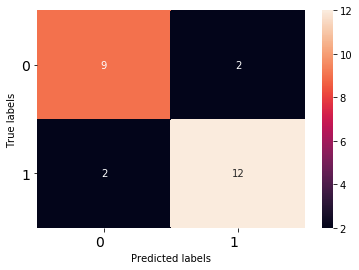

In [11]:
number_of_neighbours = 5

train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=1)

predictions = predict(validate_df, train_df, k=number_of_neighbours)

actual = validate_df["label"]

combined_df = pd.concat([actual, predictions],axis=1)

print("precision", precision(combined_df))
print("precision_", precision_(combined_df, 1))

print("recall", recall(combined_df))
print("recall_", recall_(combined_df, 1))

print("f1_score", f1_score(combined_df))
print("f1_score_", f1_score_(combined_df, 1))

print("accuracy",accuracy(combined_df))

plot_confusion_heatmap(combined_df, xticks_rotation=0)

In [12]:
# Comparison with sklearn
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import accuracy_score

# X = df.drop(["label"], axis=1)
# y = df["label"]
# X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=1)
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

model = KNeighborsClassifier(n_neighbors=number_of_neighbours)

# Train the model using the training set
model.fit(X_train, y_train)

# Predict Output
y_pred = model.predict(X_test)

# Report accuracy
accuracy_score(y_test, y_pred)

0.8

### Plot using sklearn

1 0.76;	2 0.72;	3 0.72;	4 0.72;	5 0.8;	6 0.72;	7 0.72;	8 0.72;	9 0.72;	


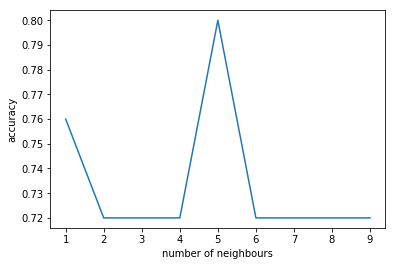

In [13]:
from math import sqrt, floor
accuracies = []
n_samples = floor(sqrt(len(train_df)))
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

for k in range(1, n_samples+1):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accu = accuracy_score(y_test, y_pred)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))

print()
plotdf = pd.DataFrame(accuracies, index=range(n_samples), columns=["number of neighbours", "accuracy"])
# sns.relplot( y="accuracy", x="number of neighbours", kind="line", data=plotdf, height=6)
sns.lineplot( y="accuracy", x="number of neighbours", data=plotdf)


### Plot using our KNN implementation

1 0.76;	2 0.68;	3 0.56;	4 0.68;	5 0.84;	6 0.8;	7 0.8;	8 0.76;	9 0.76;	


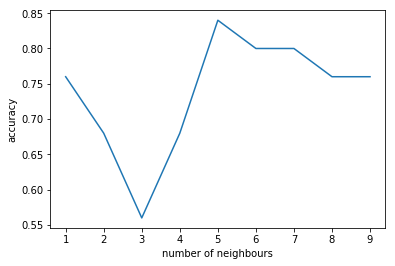

In [14]:
from math import sqrt, floor
accuracies = []
n_samples = floor(sqrt(len(train_df)))

for k in range(1, n_samples+1):
    predictions = predict(validate_df, train_df, k=k)
    actual = validate_df["label"]
    combined_df = pd.concat([actual, predictions], axis=1)
    accu = accuracy(combined_df)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))
print()    
plotdf = pd.DataFrame(accuracies, index=range(n_samples), columns=["number of neighbours", "accuracy"])
# sns.relplot( x="accuracy", y="number of neighbours", kind="line", data=plotdf, height=6)
sns.lineplot( y="accuracy", x="number of neighbours", data=plotdf)


### 1.2 Robot2


In [15]:
df = pd.read_csv("../data/robot/Robot2", header=None, sep=' ').dropna(axis=1, how='all')
# add column names header
df.columns = ["class", "a1", "a2", "a3", "a4", "a5", "a6", "Id"]

# we do not need Id column
df.drop(['Id'], axis=1, inplace=True)

# make class label the last column 
cols = df.columns.tolist()
cols.remove("class")
df = df[cols +["class"]]

target = "label"
# rename the column whose value is to be predicted to "label"
df = df.rename(columns={"class": target}) 

df.head(1)

,a1,a2,a3,a4,a5,a6,label
0,1,1,1,1,1,2,1


precision 0.9090909090909091
precision_ 0.9090909090909091
recall 1.0
recall_ 1.0
f1_score 0.9523809523809523
f1_score_ 0.9523809523809523
accuracy 0.9583333333333334


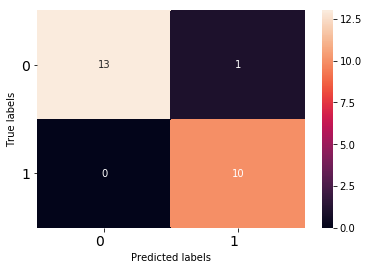

In [16]:
train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=4)
predictions = predict(validate_df, train_df, k=7)
actual = validate_df["label"]

combined_df = pd.concat([actual, predictions],axis=1)

print("precision", precision(combined_df))
print("precision_", precision_(combined_df, 1))

print("recall", recall(combined_df))
print("recall_", recall_(combined_df, 1))

print("f1_score", f1_score(combined_df))
print("f1_score_", f1_score_(combined_df, 1))

print("accuracy",accuracy(combined_df))

plot_confusion_heatmap(combined_df,xticks_rotation=0)

In [17]:
# Comparison with sklearn
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import accuracy_score

# X = df.drop(["label"], axis=1)
# y = df["label"]
# X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=1)
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

model = KNeighborsClassifier(n_neighbors=7)

# Train the model using the training set
model.fit(X_train, y_train)

# Predict Output
y_pred = model.predict(X_test)

# Report accuracy
accuracy_score(y_test, y_pred)

0.9166666666666666

1 0.9166666666666666;	2 0.9583333333333334;	3 0.9166666666666666;	4 0.9583333333333334;	5 0.9166666666666666;	6 0.9583333333333334;	7 0.9583333333333334;	8 0.9583333333333334;	9 0.9583333333333334;	10 0.9583333333333334;	11 0.9583333333333334;	12 0.9583333333333334;	13 0.9583333333333334;	14 0.9583333333333334;	15 0.9583333333333334;	16 0.9583333333333334;	17 0.9166666666666666;	18 0.9166666666666666;	19 0.875;	


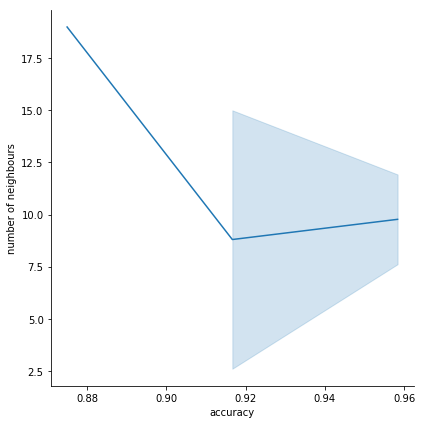

In [18]:
from math import sqrt, floor
accuracies = []
n_samples = 20 #  TODO: use floor(sqrt(len(validate_df)))

for k in range(1, n_samples):
    predictions = predict(validate_df, train_df, k=k)
    actual = validate_df["label"]
    combined_df = pd.concat([actual, predictions], axis=1)
    accu = accuracy(combined_df)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))
print()    
plotdf = pd.DataFrame(accuracies, index=range(n_samples - 1), columns=["number of neighbours", "accuracy"])
sns.relplot( x="accuracy", y="number of neighbours", kind="line", data=plotdf, height=6)


## 2. Iris.csv

In [19]:
df = pd.read_csv("../data/iris/Iris.csv", header=None, sep=',')

# add column names header
df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "label"]

df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,6.3,3.3,6.0,2.5,Iris-virginica
2,5.0,3.0,1.6,0.2,Iris-setosa


accuracy: 0.9259259259259259
precision for Iris-setosa: 1.0
precision for Iris-versicolor: 0.9
precision for Iris-virginica: 0.9
recall for Iris-setosa: 1.0
recall for Iris-versicolor: 0.9
recall for Iris-virginica: 0.9


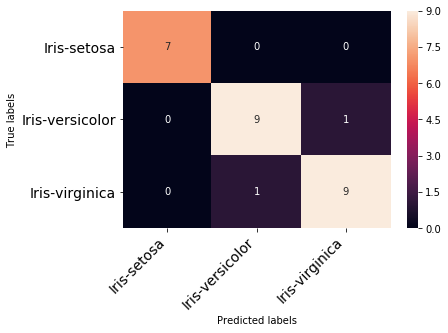

In [20]:
train_df, validate_df = train_test_split(df, test_size = 0.2, random_state=100)
predictions = predict(validate_df, train_df, k=7)
actual = validate_df["label"]

combined_df = pd.concat([actual, predictions], axis=1)

print("accuracy:", accuracy(combined_df))

print("precision for Iris-setosa:", precision_(combined_df, 'Iris-setosa'))
print("precision for Iris-versicolor:", precision_(combined_df, 'Iris-versicolor'))
print("precision for Iris-virginica:", precision_(combined_df, 'Iris-virginica'))

print("recall for Iris-setosa:", recall_(combined_df, 'Iris-setosa'))
print("recall for Iris-versicolor:", recall_(combined_df, 'Iris-versicolor'))
print("recall for Iris-virginica:", recall_(combined_df, 'Iris-virginica'))

plot_confusion_heatmap(combined_df, xticks_rotation=45)

In [21]:
# Comparison with sklearn
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import accuracy_score

# X = df.drop(["label"], axis=1)
# y = df["label"]
# X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=1)
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

model = KNeighborsClassifier(n_neighbors=7)

# Train the model using the training set
model.fit(X_train, y_train)

# Predict Output
y_pred = model.predict(X_test)

# Report accuracy
accuracy_score(y_test, y_pred)

0.9259259259259259

1 0.9629629629629629;	2 0.9629629629629629;	3 1.0;	4 0.8888888888888888;	5 0.9259259259259259;	6 0.8888888888888888;	7 0.9259259259259259;	8 0.8888888888888888;	9 0.9629629629629629;	10 0.9259259259259259;	11 0.9259259259259259;	12 0.9259259259259259;	13 0.9259259259259259;	14 0.9259259259259259;	15 0.9629629629629629;	16 0.8888888888888888;	17 0.9259259259259259;	18 0.8888888888888888;	19 0.9629629629629629;	


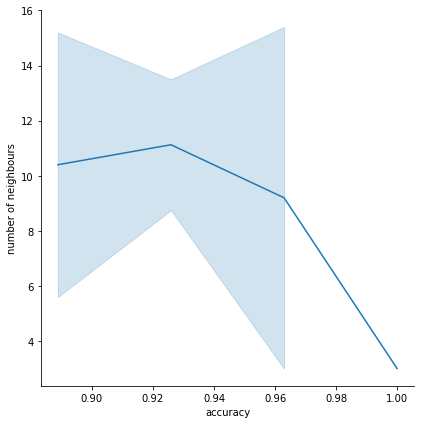

In [22]:
from math import sqrt, floor
accuracies = []
n_samples = 20 #  TODO: use floor(sqrt(len(validate_df)))
X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = validate_df.drop(["label"], axis=1), validate_df["label"]

for k in range(1, n_samples):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accu = accuracy_score(y_test, y_pred)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))

print()    
plotdf = pd.DataFrame(accuracies, index=range(n_samples - 1), columns=["number of neighbours", "accuracy"])
sns.relplot( x="accuracy", y="number of neighbours", kind="line", data=plotdf, height=6)


1 0.9629629629629629;	2 0.9629629629629629;	3 1.0;	4 0.8888888888888888;	5 0.9259259259259259;	6 0.8888888888888888;	7 0.9259259259259259;	8 0.8888888888888888;	9 0.9629629629629629;	10 0.9259259259259259;	11 0.9259259259259259;	12 0.9259259259259259;	13 0.9259259259259259;	14 0.9259259259259259;	15 0.9629629629629629;	16 0.8888888888888888;	17 0.9259259259259259;	18 0.8888888888888888;	19 0.9629629629629629;	


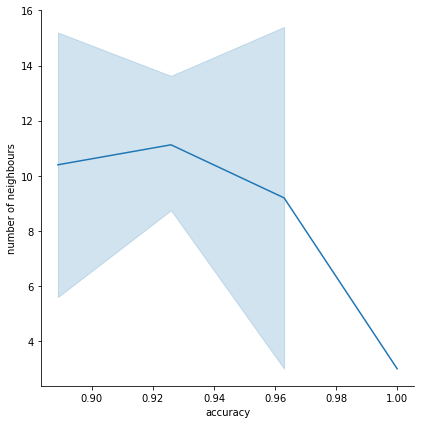

In [23]:
from math import sqrt, floor
accuracies = []
n_samples = 20 #  TODO: use floor(sqrt(len(validate_df)))

for k in range(1, n_samples):
    predictions = predict(validate_df, train_df, k=k)
    actual = validate_df["label"]
    combined_df = pd.concat([actual, predictions], axis=1)
    accu = accuracy(combined_df)
    print(k, accu, end=";\t")
    accuracies.append((k, accu))
print()    
plotdf = pd.DataFrame(accuracies, index=range(n_samples - 1), columns=["number of neighbours", "accuracy"])
sns.relplot( x="accuracy", y="number of neighbours", kind="line", data=plotdf, height=6)
